This notebook generates prediction on tracking events based on a trained U-Net and generates lineages from the predictions.

Code adapted from: https://gitlab.com/dunloplab/delta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

import sys
sys.path.append('../delta')

from data import predictCompilefromseg_track #saveResult_track, 
from model import unet_track
import utilities as utils
from skimage.measure import label, regionprops
import skimage.io as io
from skimage.transform import resize

../delta/data.py:19: UserWarning: Could not load elastic deformations module.
  warnings.warn("Could not load elastic deformations module.")


# Load data

In [2]:
DeLTA_data = '/cluster/work/sis/cdss/oschmanf/ackermann-bacteria-segmentation/delta_folder/'
images_folder = DeLTA_data + 'evaluation/preprocessed/img/Chamber_02/Position02/'
segmentation_folder = DeLTA_data + '/evaluation/seg_output/Chamber_02/Position02/'
outputs_folder = DeLTA_data + 'evaluation/track_output/'
model_file = DeLTA_data + 'unet_moma_track_multisets.hdf5'

In [3]:
img_names_sort = np.sort(os.listdir(images_folder))
seg_names_sort = np.sort(os.listdir(segmentation_folder))

# Load model and set parameters

In [4]:
# generate input for unet

def gen_input(img_names_sort, seg_names_sort, cur_frame, target_shape):
    img_cur_frame = resize(io.imread(images_folder + img_names_sort[cur_frame]), target_shape, order=1)
    img_prev_frame = resize(io.imread(images_folder + img_names_sort[cur_frame - 1]), target_shape, order=1)
    seg_cur_frame = (resize(io.imread(segmentation_folder + seg_names_sort[cur_frame]), target_shape, order=0) > 0.5).astype(int)
    seg_prev_frame = (resize(io.imread(segmentation_folder + seg_names_sort[cur_frame-1]), target_shape, order=0) > 0.5).astype(int)
    
    #inputs_cur_frame = []
    label_prev_frame = label(seg_prev_frame)
    label_cells = np.unique(label_prev_frame)
    num_cells = len(label_cells) - 1
    
    input_cur_frame = np.zeros((num_cells, target_shape[0], target_shape[1], 4))
    for i, l in enumerate(label_cells[1:]):
        seed = (label_prev_frame == l).astype(int)
        input_cur_frame[i,:,:,0] = img_prev_frame
        input_cur_frame[i,:,:,1] = seed
        input_cur_frame[i,:,:,2] = img_cur_frame
        input_cur_frame[i,:,:,3] = seg_cur_frame
    return input_cur_frame

In [5]:
# Parameters:
target_size = (512, 512)
input_size = target_size + (4,)
num_time_steps = len(img_names_sort)
#process_size = 1 # This is the number of frames to consider _BEFORE_ each sample has been subdivided into cell-specific tracking samples

# Load up model:
model = unet_track(input_size = input_size)
model.load_weights(model_file)

# # Select images to be porcessed
# unprocessed_pos_01 = list(np.sort(glob.glob(images_folder + '/Position02*')))[:num_time_steps]

# Run model to predict cell splits

In [6]:
# Process
results_all = []
inputs_all = []
inputs_seg = []
time_points = []
# t = 1
# while(unprocessed_pos_01):


#     # Pop out filenames
#     ps = min(process_size,len(unprocessed_pos_01))
#     to_process = unprocessed_pos_01[0:ps]
#     del unprocessed_pos_01[0:ps]

#     # Get data:
#     inputs, seg_filenames = predictCompilefromseg_track(images_folder, segmentation_folder,
#                                                         files_list = to_process,
#                                                         target_size = target_size)
for cur_frame in range(1, num_time_steps):
    inputs = gen_input(img_names_sort, seg_names_sort, cur_frame, target_size)
    
    if inputs.any(): # If not, probably first frame only
        # Predict:
        results_ar = []
        for i in range(inputs.shape[0]):
            results = model.predict(np.array((inputs[i,:,:,:],)),verbose=1)
            results_ar.append(results[0,:,:,:])

        results_all.append(np.array(results_ar))
        inputs_seg.append(inputs[0,:,:,3])
        inputs_all.append(inputs)
        #time_points.append(np.ones(inputs.shape[0], dtype=int)*t)
#         t += 1
            # Save (use the filenames list from the data compiler)
            #saveResult_track(outputs_folder,results, files_list = (seg_filenames[i],))



1/1 [==============================] - 0s 56ms/sample


1/1 [==============================] - 0s 55ms/sample


1/1 [==============================] - 0s 55ms/sample


1/1 [==============================] - 0s 55ms/sample


1/1 [==============================] - 0s 56ms/sample


1/1 [==============================] - 0s 55ms/sample


1/1 [==============================] - 0s 55ms/sample


1/1 [==============================] - 0s 55ms/sample


1/1 [==============================] - 0s 55ms/sample


# Generate lineages based on model output

In [7]:
# create input variables for lineage generation
timepoints=len(inputs_all) - 1
chamber_number = 0
num_track_events = [len(i) for i in inputs_all[:timepoints]]
frame_numbers = np.concatenate([[i]*num_track_events[i] for i in range(timepoints)])
seg = np.array([i[0,:,:,3] for i in inputs_all[:timepoints]])
track_inputs = np.concatenate([i for i in inputs_all[:timepoints]])
track = np.concatenate([i for i in results_all[:timepoints]])

In [8]:
# generate lineages
label_stack = np.zeros([timepoints,seg.shape[1],seg.shape[2]],dtype=np.uint16)
lin, label_stack = utils.updatelineage(seg[chamber_number*timepoints], label_stack) # Initialize lineage and label stack on first frame
for i in range(1,timepoints):
    frame_idxs = [x for x, fn in enumerate(frame_numbers) if fn==i]
    if frame_idxs:
        scores = utils.getTrackingScores(track_inputs[frame_idxs[0],:,:,3], track[frame_idxs])
        attrib = utils.getAttributions(scores)
        print(attrib.shape)
    else:
        attrib = []
    lin, label_stack = utils.updatelineage(seg[chamber_number*timepoints + i], label_stack, framenb=i, lineage=lin, attrib=attrib) # Because we use uint16, we can only track up to 65535 cells per chamber

(6, 5, 2)
(5, 5, 2)
(5, 6, 2)
(6, 6, 2)
(6, 7, 2)
(7, 6, 2)
(6, 5, 2)
(5, 5, 2)
(5, 6, 2)
(6, 7, 2)
(7, 6, 2)
(6, 5, 2)
(5, 5, 2)
(5, 5, 2)
(5, 7, 2)
(7, 7, 2)
(7, 6, 2)
(6, 5, 2)
(5, 7, 2)
(7, 6, 2)
(6, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 6, 2)
(6, 5, 2)
(5, 8, 2)
(8, 8, 2)
(8, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 6, 2)
(6, 8, 2)
(8, 7, 2)
(7, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 6, 2)
(6, 9, 2)
(9, 9, 2)
(9, 8, 2)
(8, 7, 2)
(7, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 7, 2)
(7, 7, 2)
(7, 8, 2)
(8, 8, 2)
(8, 8, 2)
(8, 8, 2)
(8, 8, 2)
(8, 7, 2)
(7, 8, 2)
(8, 7, 2)
(7, 7, 2)
(7, 10, 2)
(10, 10, 2)
(10, 9, 2)
(9, 8, 2)
(8, 7, 2)
(7, 7, 2)
(7, 6, 2)
(6, 5, 2)
(5, 9, 2)
(9, 9, 2)
(9, 8, 2)
(8, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 8, 2)
(8, 9, 2)
(9, 9, 2)
(9, 8, 2)
(8, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 7, 2)
(7, 6, 2)
(6, 8, 2)
(8, 7, 2)
(7, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 8, 2)
(8, 8, 2)
(8, 7, 2)
(7, 6, 2)
(6, 6, 2)
(6, 5, 2)
(5, 6, 2)
(6, 6, 2)
(6, 7, 2)
(7, 7, 2)
(7, 6, 2)
(6, 5, 2)
(5, 4, 2)
(4, 5, 2)
(5, 5, 2)
(5, 6, 2)
(6, 5,

# Visualize output

## Labeled cells

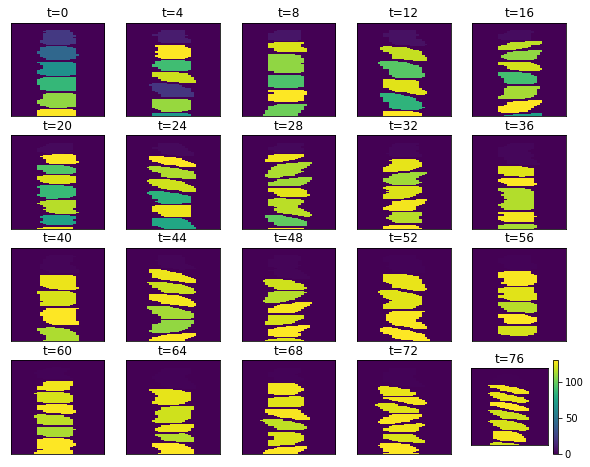

In [9]:
timeframes = np.arange(len(label_stack))
plt.figure(figsize = (10,10))
for i, l in enumerate(label_stack[::10]):
    plt.subplot(5,5,i+1)
    plt.imshow(l, vmin=label_stack.min())
    plt.title('t='+str(timeframes[::4][i]))
    plt.xticks([])
    plt.yticks([])
plt.colorbar()

## Features

In [10]:
def compute_area(cell_id):
    areas = []
    for i in range(num_time_steps-2):
        regs_cell = regionprops((label_stack[i] == cell_id).astype(int))
        try:
            areas.append(regs_cell[0].area)
        except IndexError:
            areas.append(0)
    areas = np.array(areas)
    return areas

def compute_length(cell_id):
    lengths = []
    for i in range(num_time_steps-2):
        regs_cell = regionprops((label_stack[i] == cell_id).astype(int))
        try:
            lengths.append(regs_cell[0].major_axis_length)
        except IndexError:
            lengths.append(0)
    lengths = np.array(lengths)
    return lengths

In [11]:
# Compute features

area = compute_area(cell_id = 1)
length = compute_length(cell_id = 1)

Text(0.5, 0, 'Time frame')

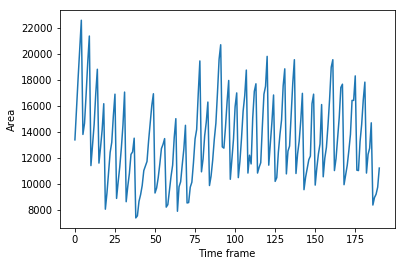

In [12]:
plt.plot(area)
plt.ylabel('Area')
plt.xlabel('Time frame')

Text(0.5, 0, 'Time frame')

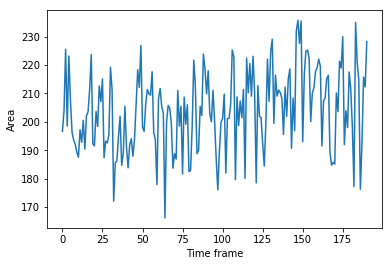

In [13]:
plt.plot(length)
plt.ylabel('Area')
plt.xlabel('Time frame')